[IPython Notebook](pot.ipynb) |  [Python Script](pot.py)

Potentials
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new Bundle.  See [Building a System](building_a_system.html) for more details.

In [35]:
%matplotlib inline

In [36]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.Bundle.default_binary()

Now let's add a MESH dataset at a few different times so that we can see how the potentials affect the surfaces of the stars.

In [37]:
b.add_dataset('MESH', time=np.linspace(0,3,11), dataset='mesh01')

<ParameterSet: 1 parameters>

Relevant Parameters
------------------------

The 'pot' parameter defines the stellar surface to be at the given Roche equipotential - and is given at periastron. By default, the 'pot' parameter is constrained (in contrast to PHOEBE legacy and Wilson-Devinney) and instead the 'rpole' parameter should be used to change the size of a star.

In [38]:
print b['pot@component']

*pot@primary@component: 8.99227787671
*pot@secondary@component: 8.99227787671


In [39]:
print b['pot@primary@component']

Qualifier: pot
Description: Potential at periastron
Value: 8.99227787671
Constrained by: rpole@primary@component, q@binary@component, ecc@binary@component, syncpar@primary@component, sma@binary@component
Constrains: None
Related to: rpole@primary@component, q@binary@component, ecc@binary@component, syncpar@primary@component, sma@binary@component


In [40]:
print b['pot@primary@constraint']

Constrains (qualifier): pot
Expression in SI (value): rpole2potential({rpole@primary@component}, {q@binary@component}, {ecc@binary@component}, {syncpar@primary@component}, {sma@binary@component}, 1)
Current Result (result): 8.99227787671


The 'rpole' parameter is defined as the polar radius of the star at periastron.

In [41]:
print b['rpole']

rpole@primary@component: 1.0 solRad
rpole@secondary@component: 1.0 solRad


In [42]:
print b['rpole@primary']

Qualifier: rpole
Description: Polar radius at periastron
Value: 1.0 solRad
Constrained by: 
Constrains: pot@primary@component
Related to: q@binary@component, ecc@binary@component, syncpar@primary@component, sma@binary@component, pot@primary@component


Polar Radius vs Potential
---------------------------------

**TODO**: explain the default setting for pot being constrained, how to flip the constraint, and common pitfalls (especially when importing from legacy)

Primary vs Secondary Potentials
------------------------------------

**TODO**: explain the transformation between primary and secondary potentials and which are provided here

Critical Potentials and System Checks
--------------------------------------------

If you set a value such that the system becomes non-computable, a logger warning will immediately be raised.  This will happen in a detached system, for example, if any of the stars are predicted to overflow at periastron.  Since the surface of the star (potential) depends on many parameters (see the constraint above), this can be triggered by changing any of:

* rpole
* pot
* q
* sma
* ecc
* syncpar

In [43]:
b.set_value('rpole@primary@component', 3)

At this time, if you were to call run_compute, an error would be thrown.  An error isn't immediately thrown when setting rpole, however, since the overflow can be recitified by changing any of the other relevant parameters.  For instance, let's change sma to be large enough to account for this value of rpole and you'll see that the error does not occur again.

In [44]:
b.set_value('sma@binary@component', 5)

In [45]:
b.set_value('sma@binary@component', 10)

These logger warnings are handy when running phoebe interactively, but in a script its also handy to be able to check whether the system is currently computable /before/ running run_compute.

This can be done by calling run_checks which returns a boolean (whether the system passes all checks) and a message (a string describing the first failed check).

In [46]:
passed, message = b.run_checks()
print passed, message

True 


In [47]:
b.set_value('sma@binary@component', 5)

In [48]:
passed, message = b.run_checks()
print passed, message

False primary is overflowing at periastron (3.75, 3.21, 3.21)


Alternatively, you could also manually check with the critical potentials.  

The set value (or constrained value) of the equipotential (which is defined at periastron) must be GREATER than the critical potentials at each of the lagrange points in order to not overflow.

In [49]:
q = b.get_value('q@binary@component')
F = b.get_value('syncpar@primary@component')
# instantaneous distance in units of sma at periastron is 1-e
d = 1 - b.get_value('ecc@binary@component')
L1_crit, L2_crit, L3_crit = phoebe.distortions.roche.critical_potential(q, F, d)
pot = b.get_value('pot@primary@component')
print "pot: {}\nL1_crit: {}\nL2_crit: {}\nL3_crit: {}".format(pot, L1_crit, L2_crit, L3_crit)

pot: 2.52415959238
L1_crit: 3.75
L2_crit: 3.20679622409
L3_crit: 3.20679622409


Here we can see that our star is overflowing at L2.  By changing the sma to a value that passed before, we see that the potential changes to a value that is allowed.

In [50]:
b.set_value('sma@binary@component', 10)

In [51]:
q = b.get_value('q@binary@component')
F = b.get_value('syncpar@primary@component')
# instantaneous distance in units of sma at periastron is 1-e
d = 1 - b.get_value('ecc@binary@component')
L1_crit, L2_crit, L3_crit = phoebe.distortions.roche.critical_potential(q, F, d)
print "pot: {}\nL1_crit: {}\nL2_crit: {}\nL3_crit: {}".format(pot, L1_crit, L2_crit, L3_crit)

pot: 2.52415959238
L1_crit: 3.75
L2_crit: 3.20679622409
L3_crit: 3.20679622409


Note that when calling critical potentials for the secondary component, you must invert q.

In [18]:
q = 1./b.get_value('q@binary@component')
F = b.get_value('syncpar@secondary@component')
# instantaneous distance in units of sma at periastron is 1-e
d = 1 - b.get_value('ecc@binary@component')
L1_crit, L2_crit, L3_crit = phoebe.distortions.roche.critical_potential(q, F, d)
pot = b.get_value('pot@secondary@component')
print "pot: {}\nL1_crit: {}\nL2_crit: {}\nL3_crit: {}".format(pot, L1_crit, L2_crit, L3_crit)

pot: 20.9987523389
L1_crit: 3.75
L2_crit: 3.20679622409
L3_crit: 3.20679622409


Accessing Synthetic Potentials and Polar Radiii
-------------------------------------

Potentials and Polar Radii are stored in the synthetic meshes for every time in which a mesh is computed.  For circular orbits, these should remain constant over time and be equivalent to the input parameters.  In the next section, we'll look at an eccentric case which will show how having access to these values as a function of time can be quite handy.

In [19]:
b.run_compute()

/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:10: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull,

<ParameterSet: 508 parameters | components: primary, secondary>

In [20]:
print b['rpole@primary@model']

0.0@rpole@primary@tmpmodel@model: 3.0 solRad
0.3@rpole@primary@tmpmodel@model: 3.0 solRad
0.6@rpole@primary@tmpmodel@model: 3.0 solRad
0.9@rpole@primary@tmpmodel@model: 3.0 solRad
1.2@rpole@primary@tmpmodel@model: 3.0 solRad
1.5@rpole@primary@tmpmodel@model: 3.0 solRad
1.8@rpole@primary@tmpmodel@model: 3.0 solRad
2.1@rpole@primary@tmpmodel@model: 3.0 solRad
2.4@rpole@primary@tmpmodel@model: 3.0 solRad
2.7@rpole@primary@tmpmodel@model: 3.0 solRad
3.0@rpole@primary@tmpmodel@model: 3.0 solRad


In [21]:
print b['rpole@secondary@model']

0.0@rpole@secondary@tmpmodel@model: 1.0 solRad
0.3@rpole@secondary@tmpmodel@model: 1.0 solRad
0.6@rpole@secondary@tmpmodel@model: 1.0 solRad
0.9@rpole@secondary@tmpmodel@model: 1.0 solRad
1.2@rpole@secondary@tmpmodel@model: 1.0 solRad
1.5@rpole@secondary@tmpmodel@model: 1.0 solRad
1.8@rpole@secondary@tmpmodel@model: 1.0 solRad
2.1@rpole@secondary@tmpmodel@model: 1.0 solRad
2.4@rpole@secondary@tmpmodel@model: 1.0 solRad
2.7@rpole@secondary@tmpmodel@model: 1.0 solRad
3.0@rpole@secondary@tmpmodel@model: 1.0 solRad


In [22]:
print b['pot@primary@model']

0.0@pot@primary@tmpmodel@model: 7.65560301953
0.3@pot@primary@tmpmodel@model: 7.65560301953
0.6@pot@primary@tmpmodel@model: 7.65560301953
0.9@pot@primary@tmpmodel@model: 7.65560301953
1.2@pot@primary@tmpmodel@model: 7.65560301953
1.5@pot@primary@tmpmodel@model: 7.65560301953
1.8@pot@primary@tmpmodel@model: 7.65560301953
2.1@pot@primary@tmpmodel@model: 7.65560301953
2.4@pot@primary@tmpmodel@model: 7.65560301953
2.7@pot@primary@tmpmodel@model: 7.65560301953
3.0@pot@primary@tmpmodel@model: 7.65560301953


In [23]:
print b['pot@secondary@model']

0.0@pot@secondary@tmpmodel@model: 20.9987523389
0.3@pot@secondary@tmpmodel@model: 20.9987523389
0.6@pot@secondary@tmpmodel@model: 20.9987523389
0.9@pot@secondary@tmpmodel@model: 20.9987523389
1.2@pot@secondary@tmpmodel@model: 20.9987523389
1.5@pot@secondary@tmpmodel@model: 20.9987523389
1.8@pot@secondary@tmpmodel@model: 20.9987523389
2.1@pot@secondary@tmpmodel@model: 20.9987523389
2.4@pot@secondary@tmpmodel@model: 20.9987523389
2.7@pot@secondary@tmpmodel@model: 20.9987523389
3.0@pot@secondary@tmpmodel@model: 20.9987523389


Eccentricity and Potentials
---------------------------------

The parameters for 'pot' and 'rpole' are defined to be at periastron, but because of volume conservation, the actual polar radius (and potential) of a star in an eccentric orbit will change as a function of phase.

Having access to the instantaneous *synthetic* values of both of the parameters as a function of time in the mesh allows us to see how the radii and potentials are changing.

In [24]:
b['ecc@binary'] = 0.1

In [25]:
b.run_compute()

/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1885: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  the_grid = cmarching.discretize(delta, maxpoints, *mesh_args)[:-2]
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/mesh.py:1168: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  new_ta

<ParameterSet: 508 parameters | components: primary, secondary>

In [26]:
print b.get_quantity('rpole@primary@component')

3.0 solRad


In [27]:
print b['rpole@primary@model']

0.0@rpole@primary@tmpmodel@model: 3.05521187669 solRad
0.3@rpole@primary@tmpmodel@model: 3.07909327575 solRad
0.6@rpole@primary@tmpmodel@model: 3.09175258533 solRad
0.9@rpole@primary@tmpmodel@model: 3.09175258533 solRad
1.2@rpole@primary@tmpmodel@model: 3.07909327575 solRad
1.5@rpole@primary@tmpmodel@model: 3.05521187669 solRad
1.8@rpole@primary@tmpmodel@model: 3.02561603394 solRad
2.1@rpole@primary@tmpmodel@model: 3.00330514843 solRad
2.4@rpole@primary@tmpmodel@model: 3.00330514843 solRad
2.7@rpole@primary@tmpmodel@model: 3.02561603394 solRad
3.0@rpole@primary@tmpmodel@model: 3.05521187669 solRad


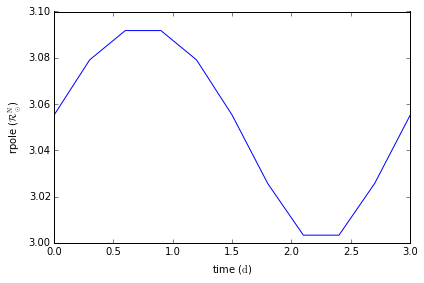

In [28]:
axs, artists = b.plot('primary@MESH@model', x='time', y='rpole')

These polar radii are changing as a function of time (phase) in order to keep the volume of the stellar surface conserved.  We can confirm that this is the case by accessing the volume as a function of time as well.

In [29]:
print b['volume@primary@model']

0.0@volume@primary@tmpmodel@model: 114.454108478 solRad3
0.3@volume@primary@tmpmodel@model: 114.454984404 solRad3
0.6@volume@primary@tmpmodel@model: 114.455293172 solRad3
0.9@volume@primary@tmpmodel@model: 114.455293172 solRad3
1.2@volume@primary@tmpmodel@model: 114.454984404 solRad3
1.5@volume@primary@tmpmodel@model: 114.454442301 solRad3
1.8@volume@primary@tmpmodel@model: 114.453835274 solRad3
2.1@volume@primary@tmpmodel@model: 114.453417629 solRad3
2.4@volume@primary@tmpmodel@model: 114.453417629 solRad3
2.7@volume@primary@tmpmodel@model: 114.453835274 solRad3
3.0@volume@primary@tmpmodel@model: 114.454108478 solRad3


(make sure to note the scale on the y-axis for the volume vs time)

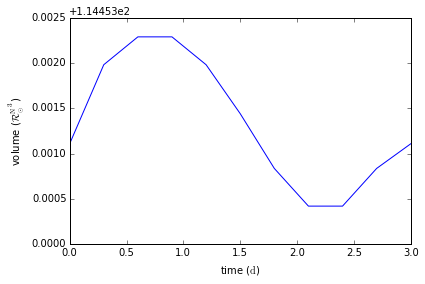

In [30]:
axs, artists = b.plot('primary@MESH@model', x='time', y='volume')

In [31]:
print b.get_quantity('pot@primary@component')

7.76265991537


In [32]:
print b['pot@primary@model']

0.0@pot@primary@tmpmodel@model: 7.64163433392
0.3@pot@primary@tmpmodel@model: 7.59062154387
0.6@pot@primary@tmpmodel@model: 7.56389752749
0.9@pot@primary@tmpmodel@model: 7.56389752749
1.2@pot@primary@tmpmodel@model: 7.59062154387
1.5@pot@primary@tmpmodel@model: 7.64163433392
1.8@pot@primary@tmpmodel@model: 7.70596342097
2.1@pot@primary@tmpmodel@model: 7.7552905731
2.4@pot@primary@tmpmodel@model: 7.7552905731
2.7@pot@primary@tmpmodel@model: 7.70596342097
3.0@pot@primary@tmpmodel@model: 7.64163433392


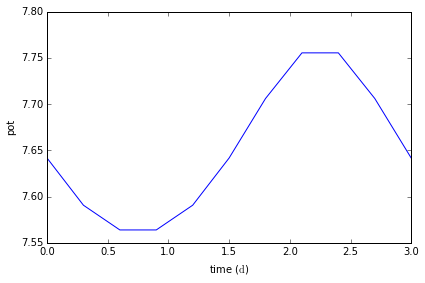

In [33]:
axs, artists = b.plot('primary@MESH@model', x='time', y='pot')

We can even see how the polar radius changes as a function of potential throughout the orbit

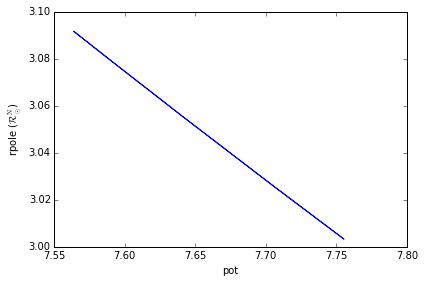

In [34]:
axs, artists = b.plot('primary@MESH@model', x='pot', y='rpole')